## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №10

### Подготовить данные для этапа моделирования (обучения)
    
Выполнить анализ данных, внести необходимые корректировки:
1. Обработать пропуски.
2. Оценить выбросы. 
3. Проверить корреляцию.
4. Выполнить тесты на нормальность распределения.
5. Масштабировать и стандартизировать данные.
6. Разделить данные на тренировочную и тестовую выборку.

Примечание: при обработке пропусков/выбросов/скалировании тестовую и тренировачную выборку обрабатывать отдельно.

Описание признаков выборки "credit_train":
 0  client_id               int64   Уникальный идентификатор клиента  
 1  gender                  object  Пол  
 2  age                     float64 Возраст  
 3  marital_status          object  Семейное положение  
 4  job_position            object  Работа  
 5  credit_sum              object  Сумма кредита  
 6  credit_month            int64   Срок кредитования  
 7  tariff_id               float64 Идентификатор предлагаемого тарифа  
 8  score_shk               object  ??? Предположительно - оценка кредитного скоринга  
 9  education               object  Образование  
 10 living_region           object  Регион проживания  
 11 monthly_income          float64 Месячный заработок  
 12 credit_count            float64 Количество кредитов  
 13 overdue_credit_count    float64 Количество просроченных кредитов  
 14 open_account_flg        int64   Решение клиента по выбору кредита (1 - клиент выбрал данный банк, 0 - другой)  

In [4]:
import pandas as pd

DATA_CSV_PATH = 'credit_train.csv'

df = pd.read_csv(DATA_CSV_PATH, sep=';', decimal=',')
df.shape

df["age"].value_counts

<bound method IndexOpsMixin.value_counts of 0          NaN
1          NaN
2         32.0
3         27.0
4         45.0
          ... 
170741    27.0
170742    24.0
170743    31.0
170744    53.0
170745    49.0
Name: age, Length: 170746, dtype: float64>

Проверим признаки на наличие пропущенных значений (NULL или NAN)

In [29]:
import numpy as np

for col in df.columns:
    pct_missing = df[col].count()
    print(f'{col} ({df[col].dtype}) - {df[col].__len__() - pct_missing}')

client_id (int64) - 0
gender (object) - 0
age (float64) - 3
marital_status (object) - 3
job_position (object) - 0
credit_sum (float64) - 2
credit_month (int64) - 0
tariff_id (object) - 0
score_shk (float64) - 7
education (object) - 5
living_region (object) - 192
monthly_income (float64) - 5
credit_count (float64) - 9230
overdue_credit_count (float64) - 9230
open_account_flg (int64) - 0


Выполним обработку пропущенных значений:  
~~-для категориальных признаков заменим пропуски на значение 'UNKNOWN'~~  
~~-для вещественных признаков заменим пропуски на значение -1~~  

Удалим все записи набора, содержащие пропущенные значения

In [30]:
'''
# Обработка категориальных признаков
df['marital_status'].fillna('UNKNOWN', inplace=True)
df['education'].fillna('UNKNOWN', inplace=True)
df['living_region'].fillna('UNKNOWN', inplace=True)

# Обработка всех прочих
df.fillna(-1, inplace=True)
'''

df = df.dropna()

df.shape

(161331, 15)

#### Проанализируем значения признаков 
- для признака living_region существует большое количество различных вариантов написания одних и тех же категорий!!! 

In [31]:
df_living_regs = df.groupby('living_region')['client_id'].count()

df_living_regs.to_csv('living_regions.csv')
df_living_regs.shape

(298,)

Выполним приведение идентичных по смыслу значений признака living_region к общему значению категории  
74 и 98 это могут быть коды ГИБДД субъектов РФ

In [32]:
import re

# Обобщение категории
def generalise(val:str):

    val = val.replace('.',' ')#.replace('-',' ')
    val = re.sub(r'^Г[ ]+|\bГ[ ]*$', '', val)
    val = re.sub(r'ОБЛАСТЬ|\b[А]?ОБЛ', '', val)
    val = re.sub(r'РЕСПУБЛИКА|\bРЕСП', '', val)
    val = re.sub(r'\bКРАЙ|\bАО|\bОКРУГ|\bАВТОНОМН[\w]*', '', val)
    val = re.sub(r'/\w*/|\(\w*\)', '', val)
    val = re.sub(r'\bЮ$|ЮГРА', '', val)

    val = val.replace('СЕВ ', 'СЕВЕРНАЯ')\
        .replace('БРЯНСКИЙ','БРЯНСКАЯ')\
        .replace('КАМЧАТСКАЯ','КАМЧАТСКИЙ')\
        .replace('МОСКВОСКАЯ','МОСКОВСКАЯ')\
        .replace('ПЕРМСКАЯ','ПЕРМСКИЙ')\
        .replace('74','ЧЕЛЯБИНСКАЯ')\
        .replace('98','САНКТ-ПЕТЕРБУРГ')\
        .replace('ЧУВАШИЯ','')\
        .replace(' -','')
    
    return val.strip(' ') 


df['living_region'] = df.apply(lambda x: generalise(x['living_region']), axis =  1)

Для признаков score_shk, credit_sum, monthly_income существуют значения отличающиеся на величину несущественную для принятия решения  
Выполним уменшение порядка значаших цифр значений на 3 порядка 

In [33]:
def reduce(val:float, size:int):
    if val > 500:
        return round(val/1000) * 1000
    else:
        return round(val*1000) / 1000

df['score_shk'] = df.apply(lambda x: reduce(x['score_shk'],1000), axis =  1)

df['credit_sum'] = df.apply(lambda x: reduce(x['credit_sum'],1000), axis =  1)

df['monthly_income'] = df.apply(lambda x: reduce(x['monthly_income'],1000), axis =  1)

In [34]:
df.groupby('age')['client_id'].count()

age
18.0       7
19.0     123
20.0     403
21.0    1129
22.0    2409
23.0    3425
24.0    4685
25.0    5560
26.0    6403
27.0    6747
28.0    7228
29.0    7231
30.0    7072
31.0    6576
32.0    6468
33.0    6411
34.0    5741
35.0    5506
36.0    5304
37.0    5131
38.0    5041
39.0    4917
40.0    4831
41.0    4543
42.0    4280
43.0    4010
44.0    3717
45.0    3167
46.0    3175
47.0    2824
48.0    2584
49.0    2331
50.0    2332
51.0    1938
52.0    1960
53.0    1904
54.0    1772
55.0    1781
56.0    1514
57.0    1401
58.0    1224
59.0    1052
60.0     941
61.0     825
62.0     760
63.0     631
64.0     552
65.0     463
66.0     361
67.0     361
68.0     234
69.0     177
70.0     138
71.0      31
Name: client_id, dtype: int64

#### Проверим набор данных на наличие дубликатов по всем признакам набора, кроме client_id и open_account_flg 
(решение по кредиту не должно отличаться при всех прочих идентичных признаках)

In [35]:
feature_list = [
    #'client_id', # идентификатор записи всегда уникальный
    'gender',
    'age',
    'marital_status',
    'job_position',
    'credit_sum',
    'credit_month',
    'tariff_id',
    'score_shk',
    'education',
    'living_region',
    'monthly_income',
    'credit_count',
    'overdue_credit_count',
    #'open_account_flg' # решение по кредиту не должно различаться при всех прочих идентичных признаках
    ]

df.groupby(feature_list)['client_id'].count().sort_values(ascending=False).head(10)

gender  age   marital_status  job_position  credit_sum  credit_month  tariff_id  score_shk  education  living_region  monthly_income  credit_count  overdue_credit_count
F       34.0  UNM             SPC           13000       10            1.6        0.528      SCH        ЧЕЛЯБИНСКАЯ    24000           4.0           0.0                     5
        46.0  DIV             SPC           10000       10            1.5        0.531      SCH        ИРКУТСКАЯ      16000           0.0           0.0                     5
M       26.0  UNM             SPC           46000       10            1.6        0.480      GRD        РОСТОВСКАЯ     35000           2.0           0.0                     4
        28.0  MAR             SPC           17000       10            1.4        0.480      SCH        САМАРСКАЯ      35000           0.0           0.0                     4
F       36.0  DIV             SPC           15000       10            1.43       0.670      SCH        ПЕНЗЕНСКАЯ     30000           1

Выполним удаление записей-дубликатов

In [36]:
df = df.drop_duplicates(feature_list, keep='first')
df.shape

(159694, 15)

#### Выполним обнаружение выбросов (Нетипичных данных)

Проведем анализ описательной статистики набора данных - значений квартилей 25, 50, 75% и минимальных-максимальных значений признаков

In [37]:
df.describe()

,client_id,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000
mean,85080.653757,37.051154,25916.790863,10.996017,0.464907,40406.759177,2.107387,0.046094,0.165830
std,49278.085176,10.407251,16185.531646,3.552335,0.122001,25309.857508,1.776218,0.211504,0.371929
min,8.000000,18.000000,3000.000000,3.000000,0.000000,5000.000000,0.000000,0.000000,0.000000
25%,42371.250000,29.000000,15000.000000,10.000000,0.377000,25000.000000,1.000000,0.000000,0.000000
50%,84924.500000,35.000000,21000.000000,10.000000,0.458000,35000.000000,2.000000,0.000000,0.000000
75%,127740.500000,43.000000,32000.000000,12.000000,0.546000,50000.000000,3.000000,0.000000,0.000000
max,170746.000000,71.000000,200000.000000,36.000000,0.976000,950000.000000,21.000000,3.000000,1.000000


Построим коробчатую диаграмму признаков

(принято считать что любые точки данных ниже или выше границ диаграммы рассматриваются как выбросы.)

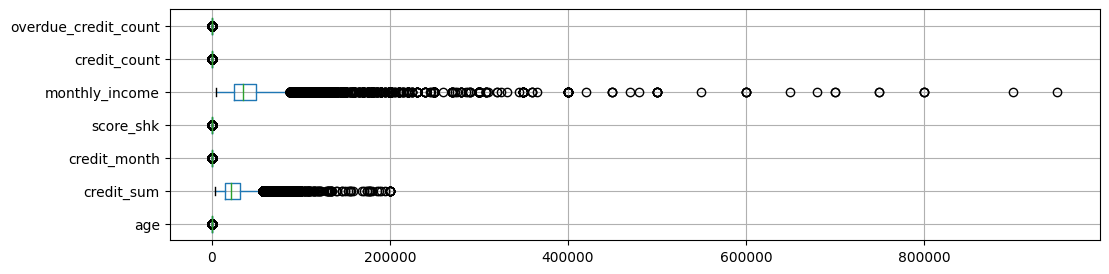

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))

bp = df.boxplot(column=['age','credit_sum','credit_month','score_shk','monthly_income','credit_count','overdue_credit_count'], vert=0, return_type='both' )

#### Выполним удаление выбросов данных

Используя межквартильный диапазон IQR = Q3(квартиль 75%) - Q1(квартиль 25%)

In [39]:
import scipy.stats as stats

cols = ['age','credit_sum','credit_month','score_shk','monthly_income','credit_count','overdue_credit_count']

# Размерность исходного набора данных
print(f'Размерность исходного наборы данных : {df.shape}')

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR= df[cols].apply(stats.iqr)

df_cleaned = df[~((df[cols] < (Q1-1.5*IQR)) | (df[cols] > (Q3+1.5*IQR))).any(axis=1)]

# Размерность очищенного набора данных (метод межквартельного интревала)
print(f'Размерность очищенного набора данных (метод межквартельного интервала) : {df_cleaned.shape}')
df_cleaned.describe()

Размерность исходного наборы данных : (159694, 15)
Размерность очищенного набора данных (метод межквартельного интервала) : (115754, 15)


,client_id,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,115754.000000,115754.000000,115754.000000,115754.000000,115754.000000,115754.000000,115754.000000,115754.0,115754.000000
mean,85189.325734,36.579885,23326.848316,10.677679,0.466974,36128.557112,1.883460,0.0,0.154345
std,49271.710101,10.015078,11588.865258,1.085362,0.117746,15713.230651,1.478758,0.0,0.361280
min,8.000000,18.000000,3000.000000,7.000000,0.132000,6000.000000,0.000000,0.0,0.000000
25%,42487.250000,29.000000,15000.000000,10.000000,0.380000,25000.000000,1.000000,0.0,0.000000
50%,85224.500000,35.000000,20000.000000,10.000000,0.457000,33000.000000,2.000000,0.0,0.000000
75%,127898.750000,43.000000,29000.000000,12.000000,0.545000,45000.000000,3.000000,0.0,0.000000
max,170746.000000,64.000000,57000.000000,15.000000,0.799000,87000.000000,6.000000,0.0,1.000000


### !!!В результате удаления выбросов были потеряны существенные данные по признаку overdue_credit_count!!!  

In [40]:
#df = df_cleaned

#### Проверим количество уникальных значений для признаков

In [41]:
#for col in df.columns:
#    print(f'{col} - количество уникальных значений = {df[col].nunique()}')

#### Выполним преобразование типа столбцов категориальных признаков к типу "categiry"

In [42]:
categorical_features = [
    'gender',
    'marital_status',
    'job_position',
    'tariff_id',
    'education',
    'living_region',
    'open_account_flg'
    ]

df[categorical_features] = df[categorical_features].astype('category')

df[['age','credit_count','overdue_credit_count']] = df[['age','credit_count','overdue_credit_count']].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159694 entries, 7 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   client_id             159694 non-null  int64   
 1   gender                159694 non-null  category
 2   age                   159694 non-null  int32   
 3   marital_status        159694 non-null  category
 4   job_position          159694 non-null  category
 5   credit_sum            159694 non-null  int64   
 6   credit_month          159694 non-null  int64   
 7   tariff_id             159694 non-null  category
 8   score_shk             159694 non-null  float64 
 9   education             159694 non-null  category
 10  living_region         159694 non-null  category
 11  monthly_income        159694 non-null  int64   
 12  credit_count          159694 non-null  int32   
 13  overdue_credit_count  159694 non-null  int32   
 14  open_account_flg      159694 non-nul

#### Выполним кодирование категориальных признаков
Значения категориальных признаков являются номинальными, неупорядоченными данными;   
Для избежания потери информации из-за снижения размерности применим метод кодирования One-Hot Encoding 

In [43]:
df_cats_dummed = pd.get_dummies(df, categorical_features, prefix_sep='_', drop_first=False)
df_cats_dummed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159694 entries, 7 to 170745
Columns: 163 entries, client_id to open_account_flg_1
dtypes: float64(1), int32(3), int64(4), uint8(155)
memory usage: 32.7 MB


In [44]:
df_cats_dummed.describe()

,client_id,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,gender_F,gender_M,...,living_region_ЧЕЛЯБИНСКАЯ,living_region_ЧЕЧЕНСКАЯ,living_region_ЧИТИНСКАЯ,living_region_ЧУВАШСКАЯ,living_region_ЧУКОТСКИЙ,living_region_ЭВЕНКИЙСКИЙ,living_region_ЯМАЛО-НЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ,open_account_flg_0,open_account_flg_1
count,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,...,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000,159694.000000
mean,85080.653757,37.051154,25916.790863,10.996017,0.464907,40406.759177,2.107387,0.046094,0.521266,0.478734,...,0.030414,0.000150,0.000106,0.005354,0.000169,0.000006,0.011747,0.005410,0.834170,0.165830
std,49278.085176,10.407251,16185.531646,3.552335,0.122001,25309.857508,1.776218,0.211504,0.499549,0.499549,...,0.171725,0.012258,0.010317,0.072975,0.013002,0.002502,0.107748,0.073356,0.371929,0.371929
min,8.000000,18.000000,3000.000000,3.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42371.250000,29.000000,15000.000000,10.000000,0.377000,25000.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,84924.500000,35.000000,21000.000000,10.000000,0.458000,35000.000000,2.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,127740.500000,43.000000,32000.000000,12.000000,0.546000,50000.000000,3.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,170746.000000,71.000000,200000.000000,36.000000,0.976000,950000.000000,21.000000,3.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Проверка исходных данных на нормальность

Построим распределение исходных данных с помощью гистограмм

array([[<AxesSubplot:title={'center':'credit_count'}>]], dtype=object)

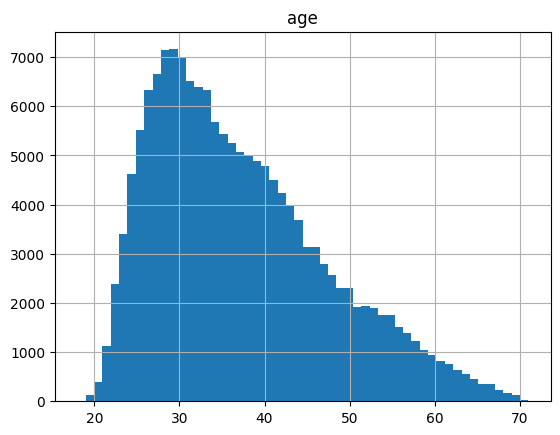

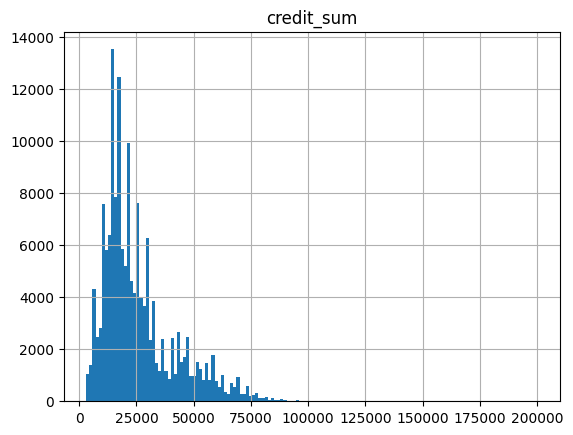

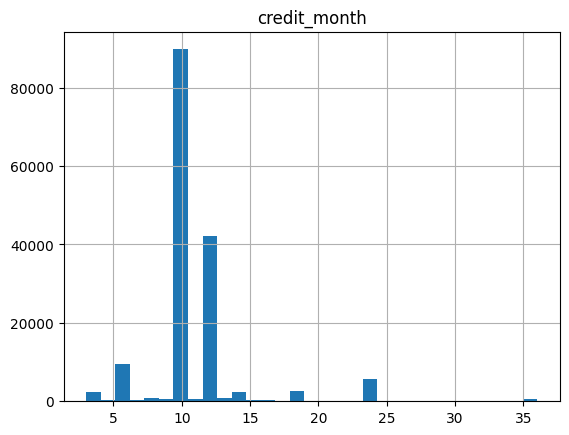

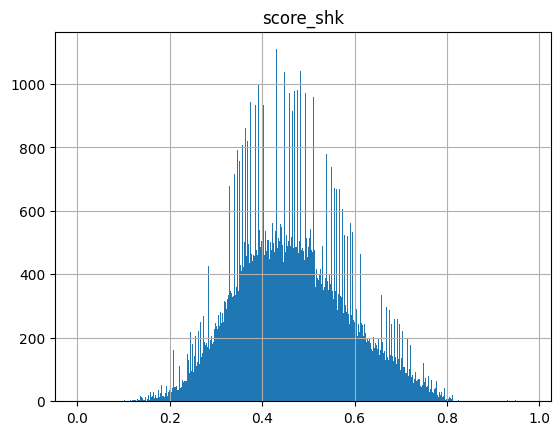

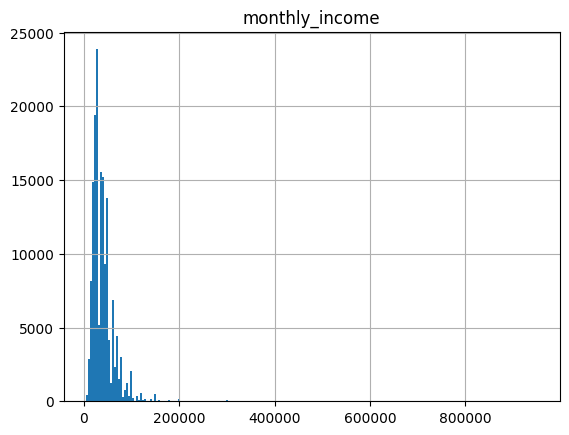

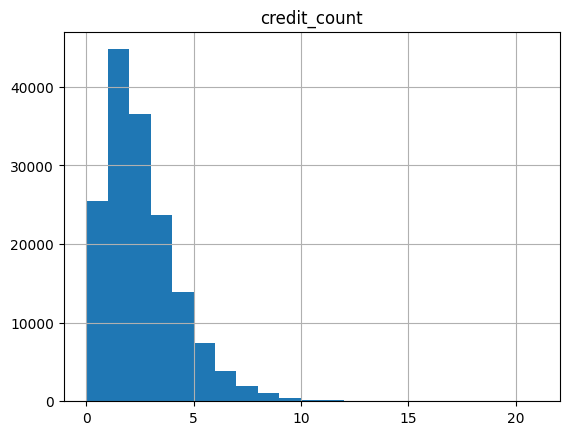

In [45]:
age_bins = df['age'].value_counts().count()
credit_sum_bins = df['credit_sum'].value_counts().count()
credit_month_bins = df['credit_month'].value_counts().count()
score_shk_bins = df['score_shk'].value_counts().count()
monthly_income_bins = df['monthly_income'].value_counts().count()
credit_count_bins = df['credit_count'].value_counts().count()
overdue_credit_count_bins = df['overdue_credit_count'].value_counts().count()

df.hist(column = ['age'], bins= age_bins)
df.hist(column = ['credit_sum'], bins= credit_sum_bins)
df.hist(column = ['credit_month'], bins= credit_month_bins)
df.hist(column = ['score_shk'], bins= score_shk_bins)
df.hist(column = ['monthly_income'], bins= monthly_income_bins)
df.hist(column = ['credit_count'], bins= credit_count_bins)


#### Выполним нормализацию значений признаков с порядковыми данными
Применим метод MinMax масштабирования

In [1]:
cols_original = ['age','credit_sum','credit_month','score_shk','monthly_income','credit_count','overdue_credit_count']

min_max_df = df.copy(deep=True)

for col in min_max_df[cols_original].columns:
    min_max_df[cols_original] = (min_max_df[cols_original] - min_max_df[cols_original].min()) / (min_max_df[cols_original].max() - min_max_df[cols_original].min())

min_max_df.head(5)

df = min_max_df

df.value_counts()

NameError: name 'df' is not defined

~~Применим метод Z-оценки (Стандартизация)~~

In [47]:
'''
cols_original = ['age','credit_sum','credit_month','score_shk','monthly_income','credit_count','overdue_credit_count']

z_mean_df = df.copy(deep=True)

for col in z_mean_df[cols_original].columns:
    z_mean_df[cols_original] = (z_mean_df[cols_original] - z_mean_df[cols_original].median()) / z_mean_df[cols_original].std()

z_mean_df.head(5)

df = z_mean_df
'''

"\ncols_original = ['age','credit_sum','credit_month','score_shk','monthly_income','credit_count','overdue_credit_count']\n\nz_mean_df = df.copy(deep=True)\n\nfor col in z_mean_df[cols_original].columns:\n    z_mean_df[cols_original] = (z_mean_df[cols_original] - z_mean_df[cols_original].median()) / z_mean_df[cols_original].std()\n\nz_mean_df.head(5)\n\ndf = z_mean_df\n"

#### Построение матрицы корреляции признаков

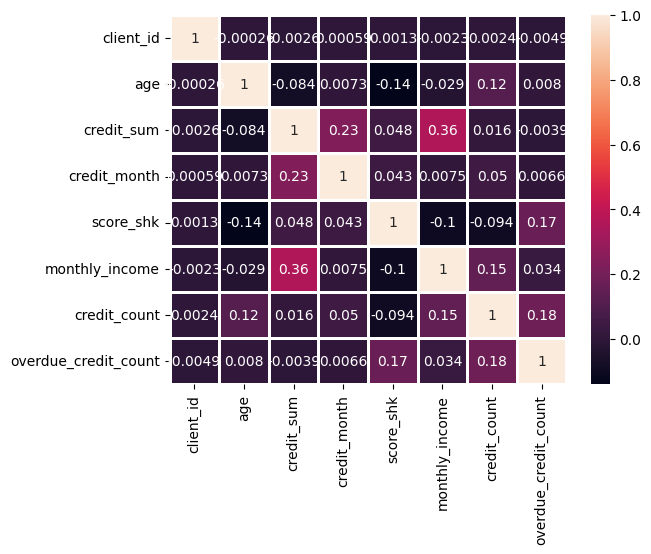

In [48]:
import matplotlib.pyplot as plt
import seaborn as sn

# Используем нормализованные данные
#df = z_mean_df
cols = [
    'gender',
    'age',
    'marital_status',
    'job_position',
    'credit_sum',
    'credit_month',
    'tariff_id',
    'score_shk',
    'education',
    'living_region',
    'monthly_income',
    'credit_count',
    'overdue_credit_count',
    'open_account_flg']

sn.heatmap(df.corr(), annot=True, linewidths=1)
plt.show()

#### Выполним разбиение исходной выборки данных на 3 подмножества (обучение, проверка и тестирование)

In [49]:
train, validate, test = np.split(df, [int(.7*len(df)), int(.85*len(df))])

print(f'Размерность исходной выборки - {df.shape}')
print(f'Размерность обучающей (train) выборки - {train.shape}')
print(f'Размерность проверочной (validation) выборки - {validate.shape}')
print(f'Размерность тестовой (test) выборки - {test.shape}')

Размерность исходной выборки - (159694, 15)
Размерность обучающей (train) выборки - (111785, 15)
Размерность проверочной (validation) выборки - (23954, 15)
Размерность тестовой (test) выборки - (23955, 15)
